# Convolutional Variational Autoencoder with custom data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/My Drive/Dessertation codes')

##import data

In [3]:
import helper_data
import helper_evaluate
import helper_plotting
import helper_train
import helper_utils

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [5]:
from helper_data import get_dataloader_custom
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [6]:
##########################
### SETTINGS
##########################

# Device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("GPU is available")
else:
    DEVICE = torch.device("cpu")
    print("GPU is not available")
#print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 1
NUM_EPOCHS = 200
num_workers=2

GPU is available


In [7]:

set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [8]:
##########################
### Dataset
##########################

train_loader = get_dataloader_custom(batch_size=BATCH_SIZE, num_workers=num_workers)

In [9]:

# Checking the dataset
print('Training Set:')
print('Number of batches:', len(train_loader))
print('Number of samples:', len(train_loader.dataset))

for images in train_loader:
    print('Image batch dimensions:', images.size())
    break

Training Set:
Number of batches: 280
Number of samples: 280
Image batch dimensions: torch.Size([1, 3, 256, 256])


## Model

In [10]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :256, :256]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(262144, 2)   #64*64*64=262144 for 256*256 size
        self.z_log_var = torch.nn.Linear(262144, 2)

        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 262144),
                Reshape(-1, 64, 64, 64),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 3, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [11]:

set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [12]:

log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=DEVICE,
                        train_loader=train_loader,
                        skip_epoch_stats=False,
                        logging_interval=50)

starting training
Epoch: 001/200 | Batch 0000/0280 | Loss: 34349.4297
Epoch: 001/200 | Batch 0050/0280 | Loss: 12371.7891
Epoch: 001/200 | Batch 0100/0280 | Loss: 13144.5244
Epoch: 001/200 | Batch 0150/0280 | Loss: 7998.1304
Epoch: 001/200 | Batch 0200/0280 | Loss: 6140.3994
Epoch: 001/200 | Batch 0250/0280 | Loss: 13739.6387
***Epoch: 001/200 | Loss: 12913.311 | Reconstruction Loss: 12788.468 | KL Divergence: 124.843
Time elapsed: 0.23 min
Epoch: 002/200 | Batch 0000/0280 | Loss: 14374.4854
Epoch: 002/200 | Batch 0050/0280 | Loss: 7436.3242
Epoch: 002/200 | Batch 0100/0280 | Loss: 12106.7598
Epoch: 002/200 | Batch 0150/0280 | Loss: 8239.1172
Epoch: 002/200 | Batch 0200/0280 | Loss: 6027.2681
Epoch: 002/200 | Batch 0250/0280 | Loss: 15164.2324
***Epoch: 002/200 | Loss: 10536.951 | Reconstruction Loss: 10385.176 | KL Divergence: 151.776
Time elapsed: 0.44 min
Epoch: 003/200 | Batch 0000/0280 | Loss: 14008.7549
Epoch: 003/200 | Batch 0050/0280 | Loss: 7378.7100
Epoch: 003/200 | Batch 010

## Evaluation

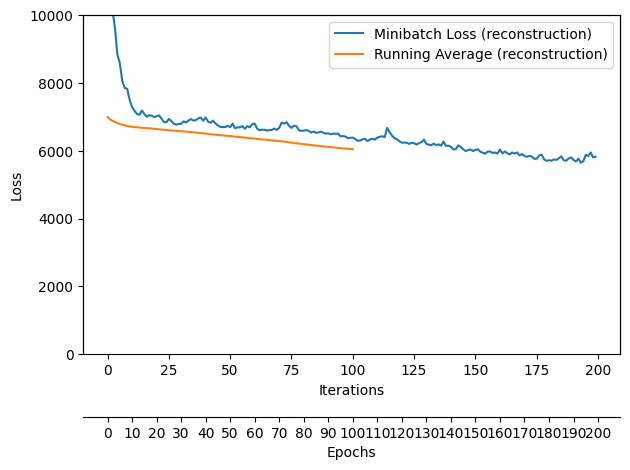

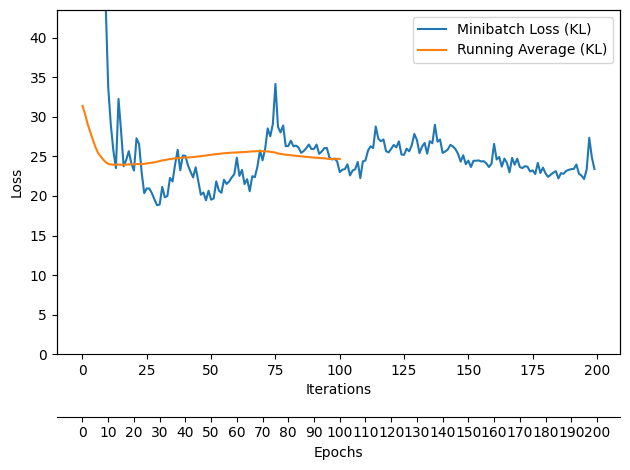

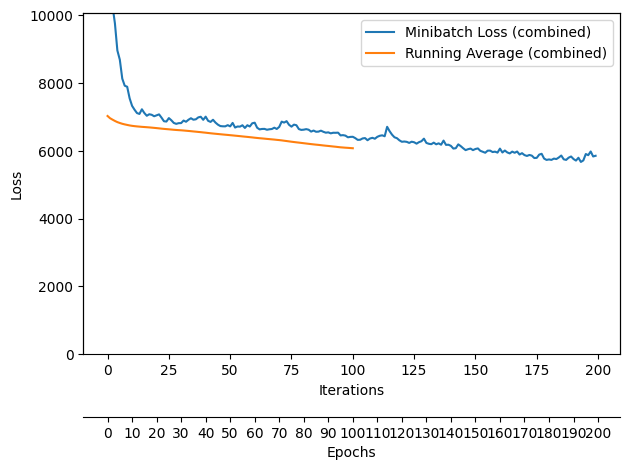

In [13]:
plot_training_loss(log_dict['total_reconstruction_loss_epoch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['total_kl_loss_epoch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_total_loss_per_epoch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False
Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False
Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False
Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False
Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False
Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False
Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False
Are decoded_images_1, decoded_images_2, and decoded_images_3 equal? False


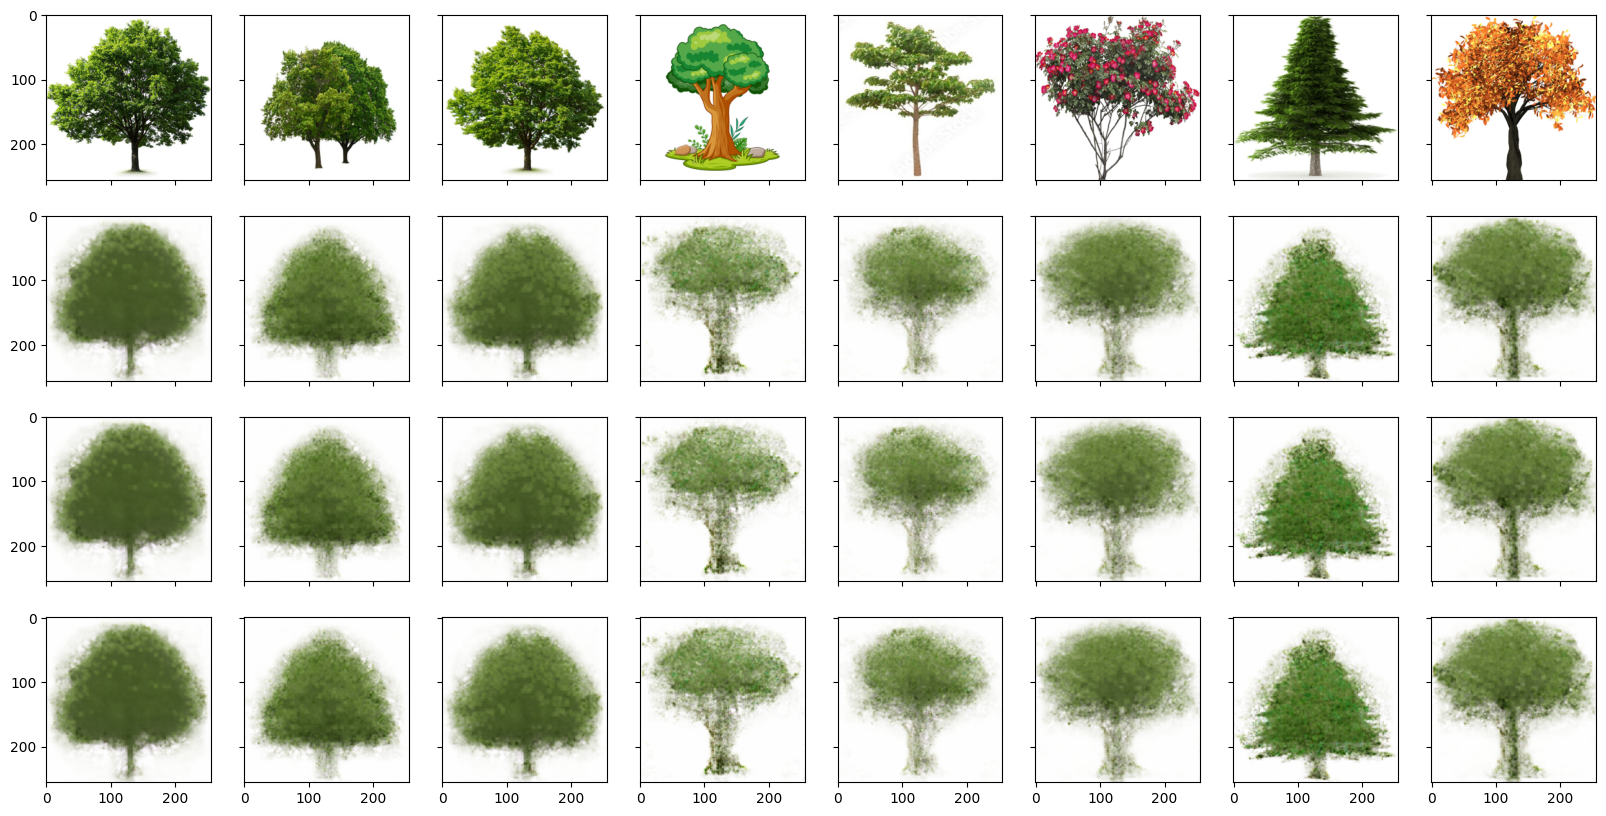

In [14]:

image_indices = [1, 80, 7, 258,259,240,243,254]

plot_generated_images(data_loader=train_loader, model=model, device=DEVICE, image_indices=image_indices,
                      figsize=(20, 10), modeltype='VAE')

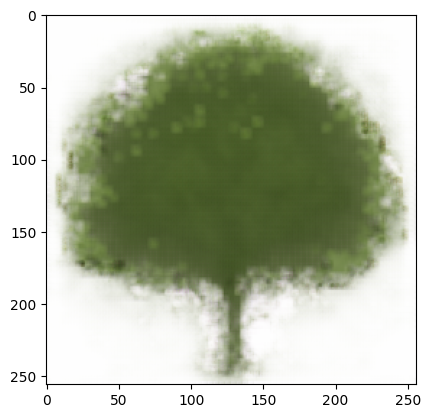

In [15]:
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    new_image = model.decoder(torch.tensor([-0.0, 0.03]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)

# Transpose the tensor to (256, 256, 3)
new_image_transposed = new_image.permute(1, 2, 0)

plt.imshow(new_image_transposed.to('cpu').numpy(), cmap='binary')
plt.show()


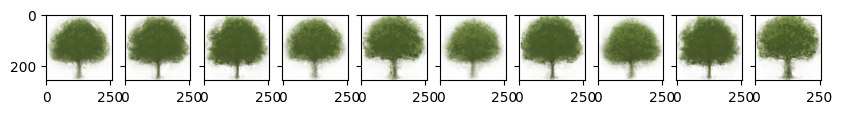

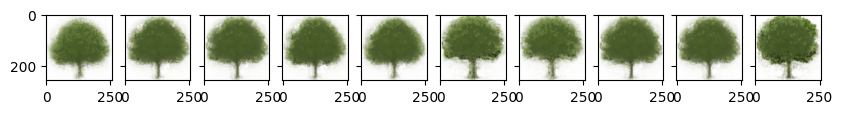

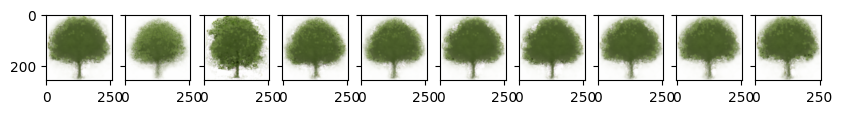

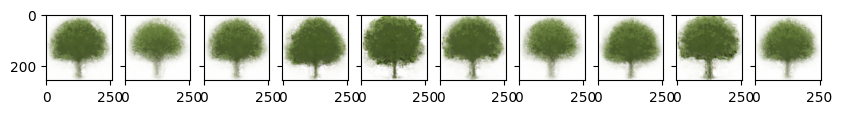

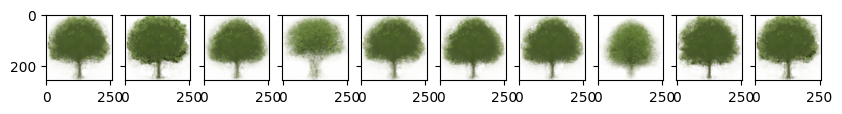

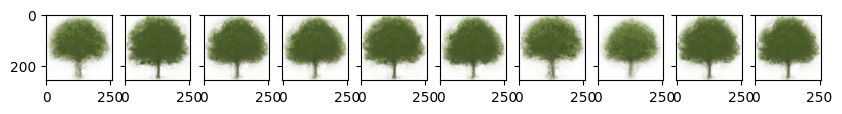

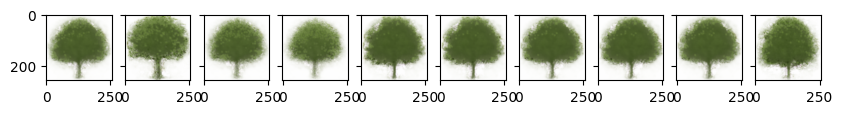

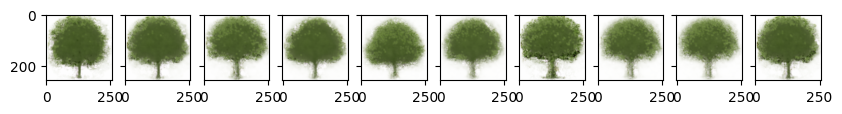

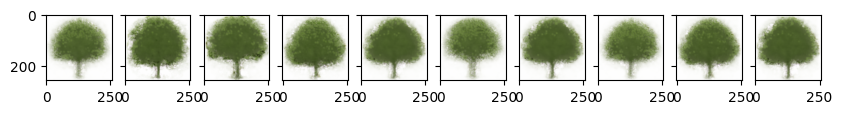

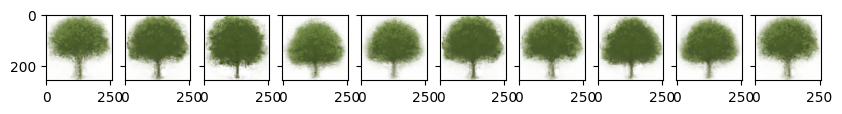

In [16]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=2)
    plt.show()